In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# **Ouverture du csv, un peu long car volumineux**

In [ ]:
df=pd.read_csv('/content/gdrive/My Drive/Val_projet/airbnb.csv',";")

Le dataframe est immense et nous n'allons pas tout utiliser, nous supprimons toutes les colonnes qui ne sont pas utiles à notre recherche. Nous pourrons toujours venir les rechercher si nous en avons le besoin


In [ ]:
#Premiere supression de variables pas utiles à notre analyse
df=df.drop(['Listing Url','Scrape ID','Last Scraped','Host Acceptance Rate','Scrape ID','Last Scraped',
            'Thumbnail Url','Medium Url','Picture Url','XL Picture Url','Host URL','Host Acceptance Rate',
           'Host Thumbnail Url','Host Picture Url','Host Verifications','Neighbourhood','Neighbourhood Group Cleansed',
           'Geolocation','Has Availability','Calendar last Scraped','License','Jurisdiction Names'], axis=1)

In [ ]:
#deuxieme supression de variables pas utiles à notre analyse
df=df.drop(['Summary','Space','Experiences Offered','Notes','Access','State','Zipcode','Host Name','Host Location','Host Neighbourhood', 'Host ID',
           'Host Listings Count','Smart Location','Country Code','Square Feet','Security Deposit','Calendar Updated',
            'Guests Included','Extra People','Street','Country','Cancellation Policy','Calculated host listings count','Features','Market'], axis=1)

In [ ]:
#On rename les colonnes qui ont des espaces
df.rename(columns={'ID':"id",'Name': 'name', 'Description': 'description', 'Host About': 'host_about', 'Host Response Time': 'host_response_time', 'Host Response Rate': 'host_response_rate', 'Host Total Listings Count': 'host_total_listing_count', 'Neighbourhood Cleansed': 'neighbourhood_cleansed' , 'City': 'city', 'Property Type': 'property_type', 'Room Type': 'room_type', 'Accommodates': 'accommodates'
, 'Bathrooms': 'bathrooms', 'Bedrooms': 'bedrooms', 'Beds': 'beds', 'Bed Type': 'bed_type', 'Amenities': 'amenities', 'Price': 'price', 'Weekly Price': 'weekly_price', 'Monthly Price': 'monthly_price', 'Cleaning Fee': 'cleaning_fee', 'Minimum Nights': 'minimum_nights', 'Maximum Nights': 'maximum_nights', 'Availability 30': 'availability_30', 'Availability 60': 'availability_60', 'Availability 90': 'availability_90', 'Availability 365': 'availability_365', 'Number of Reviews': 'number_of_reviews', 'First Review': 'first_review'
, 'Last Review': 'last_review', 'Review Scores Rating': 'review_scores_rating', 'Review Scores Accuracy': 'review_scores_accuracy', 'Review Scores Cleanliness': 'review_scores_cleanliness', 'Review Scores Checkin': 'review_scores_checkin', 'Review Scores Communication': 'review_scores_communication', 'Review Scores Location': 'review_scores_location', 'Review Scores Value': 'review_scores_value', 'Reviews per Month': 'reviews_per_month', 'Longitude': 'longitude','Latitude': 'latitude',"Neighborhood Overview":"neighborhood_overview","Transit":"transit","Interaction":"interaction","House Rules":"house_rules","Host Since":"host_since"}, inplace=True)

In [ ]:
# on met la colonne id en index

df=df.set_index("id")

In [ ]:
#Nous allons nous concentrer sur les villes de Paris et Londres, avant de commencer le nettoyage nous allons garder uniquement toutes les données concernant ces deux villes

#on divise le df par villes puis on les regroupe dans df
df_paris=df[df.city=='Paris']
df_london=df[df.city=='London']
df = df_paris.append(df_london)

# **Démarrons maintenant le nettoyage**

In [ ]:
#On supprime les lignes dont les reviews ne sont pas renseignés étant donnée que c'est un point important de notre analyse
df=df.dropna(axis=0,subset=["first_review","last_review","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value","reviews_per_month"])

In [ ]:
#Maintenant que toutes les données ont une note attribuée, nous allons affiner en retirant les lignes qui ont des nans et qui peuvent fausser notre analyse.
df=df.dropna(axis=0,subset=["description","name","host_since","host_total_listing_count","price"]) 

In [ ]:
#On supprime ces deux variables qui présentent trop de données manquantes pour être exploitées et qui sont difficiles à remplacer sans impacter les résultats de l'analyse
df=df.drop(['host_response_time','host_response_rate'], axis=1)

In [ ]:

df["neighborhood_overview"]=df["neighborhood_overview"].fillna("nr")
df["transit"]=df["transit"].fillna("nr")
df["interaction"]=df["interaction"].fillna("nr")
df["house_rules"]=df["house_rules"].fillna("nr")
df["host_about"]=df["host_about"].fillna("nr")
df["amenities"]=df["amenities"].fillna("nr")
df["bathrooms"]=df["bathrooms"].fillna(0)
df["bedrooms"]=df["bedrooms"].fillna(0)
df["beds"]=df["beds"].fillna(0)
df["weekly_price"]=df["weekly_price"].fillna(0)
df["monthly_price"]=df["monthly_price"].fillna(0)
df["cleaning_fee"]=df["cleaning_fee"].fillna(0)


In [ ]:

#On stock les variables numérique dans num_df
num_df=df.select_dtypes(include="float64")



 Il semble y avoir des valeurs abérrantes dans maximum_nights pour avoir des valeurs si élevées

 Nous allons donc regarder cette variable ainsi que minimum_nights

In [ ]:
#On change les valeur aberrante (qui depasse 365jours) de maximum_nights en valeur de la variable 'availability_365', qui semble plus logique
num_df['maximum_nights'] = np.where(num_df['maximum_nights'] > 365, num_df['availability_365'], num_df['maximum_nights'])


In [ ]:
#On modifie les valeurs abérrantes de minimum_nights en remplaçant toutes les valeurs au dessus de 31 jours par 1
num_df.minimum_nights[num_df.minimum_nights > 31] = 1


# **Analyse des variables catégorielles**

In [ ]:
#On determine les variables catégorielles et on les stock dans cat_df
cat_df = df.select_dtypes(include=['O'])

In [ ]:
#Nous allons garder uniquement les types de propriété 'Apartment' et 'House' qui représente 99,6% du dataset
cat_df['property_type']=cat_df['property_type'].loc[cat_df['property_type'].isin(['Apartment','House'])]

#On supprime les ligne qui ne sont pas des appartement ou maison (devenu Nans avec le code précédent) 
cat_df=cat_df.dropna(axis=0,subset=['property_type'])

In [ ]:
#Nous allons garder uniquement les types de chambre 'Entire home/apt' et 'Private room' qui représente 99,9% du dataset
cat_df['room_type']=cat_df['room_type'].loc[cat_df['room_type'].isin(['Entire home/apt','Private room'])]

#On supprime les ligne qui ne sont pas des 'Entire home/apt' ou 'Private room' (devenu Nans avec le code précédent) 
cat_df=cat_df.dropna(axis=0,subset=['room_type'])

beaucoup de variables catégorielles sont remplies librement par les propriétaires et donc quasiment toutes différentes.
Il conviendra donc de faire du text mining pour les analyser ultérieurement. 

In [ ]:
#On ré-assemble le dataframe variable numerique + variable catégorielles
df=pd.concat([num_df,cat_df],axis=1)

In [ ]:
# Mettons maintenant ces variables au format datetime

df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])

In [ ]:
#Maintenant le que le df est reconstitué, on supprime les lignes qui contiennent des Nans du fait des changements dans cat_df
df=df.dropna(axis=0)


In [ ]:
#on divise le df par villes puis on les regroupe dans df pour ecraser les données précédentes de df_london et df_paris
df_paris=df[df.city=='Paris']
df_london=df[df.city=='London']
#On supprimme la première ligne de df_london car elle pose problème pour la visualisation par la suite et elle contient beaucoup de valeurs "Non-renseignées"
df_london.drop( df_london.index[0], inplace=True)
df = df_paris.append(df_london)

In [ ]:
# Importations

## for data
import collections
import json
## for plotting
import wordcloud
## for text processing
import re
import nltk
## for language detection
!pip install langdetect
import langdetect 
## for sentiment
from textblob import TextBlob
## for ner
import spacy
## for vectorizer
from sklearn import feature_extraction, manifold
## for word embedding
import gensim.downloader as gensim_api
## for topic modeling
import gensim

     |████████████████████████████████| 981 kB 7.3 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=20765a574f31f9592fa020c64c3fa924700685615bb76461629c2d5c10d5f309
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [ ]:
amenities_string =  "\n\n".join(df.amenities)



In [ ]:
#Commençons par nettoyer les données textuelles de la variable amenities

amenities_string = re.sub('\s+',' ',amenities_string).strip().lower()
amenities_string[:600]

'wireless internet,kitchen,elevator in building,buzzer/wireless intercom,heating,smoke detector,essentials,shampoo,hangers,hair dryer,iron,laptop friendly workspace,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50,self check-in,doorman entry tv,internet,wireless internet,kitchen,heating,family/kid friendly tv,cable tv,internet,wireless internet,kitchen,hot tub,heating,family/kid friendly,washer,dryer,essentials,shampoo,24-hour check-in,hangers,hair dryer,iron,laptop friendly workspace tv,cable tv,internet,wireless internet,kitchen,indoor fireplace,buzzer/wir'

In [ ]:
r=re.compile(r"[0-9]")
amenities_string=r.sub(" ",amenities_string)
amenities_string[:600]

'wireless internet,kitchen,elevator in building,buzzer/wireless intercom,heating,smoke detector,essentials,shampoo,hangers,hair dryer,iron,laptop friendly workspace,translation missing: en.hosting_amenity_  ,translation missing: en.hosting_amenity_  ,self check-in,doorman entry tv,internet,wireless internet,kitchen,heating,family/kid friendly tv,cable tv,internet,wireless internet,kitchen,hot tub,heating,family/kid friendly,washer,dryer,essentials,shampoo,  -hour check-in,hangers,hair dryer,iron,laptop friendly workspace tv,cable tv,internet,wireless internet,kitchen,indoor fireplace,buzzer/wir'

In [ ]:
r=re.compile(r"[\-\.\:\)\(\,\+\*\#\!\_\?\@\°\<\>\&\;\'\"\[\]\[/]]")
amenities_string=r.sub(" ",amenities_string)
amenities_string[:600]

'wireless internet kitchen elevator in building buzzer/wireless intercom heating smoke detector essentials shampoo hangers hair dryer iron laptop friendly workspace translation missing  en hosting amenity    translation missing  en hosting amenity    self check in doorman entry tv internet wireless internet kitchen heating family/kid friendly tv cable tv internet wireless internet kitchen hot tub heating family/kid friendly washer dryer essentials shampoo    hour check in hangers hair dryer iron laptop friendly workspace tv cable tv internet wireless internet kitchen indoor fireplace buzzer/wir'

In [ ]:
r=re.compile(r"[\s]{2,}")
amenities_string=r.sub(" ",amenities_string)
amenities_string[:600]

'wireless internet kitchen elevator in building buzzer/wireless intercom heating smoke detector essentials shampoo hangers hair dryer iron laptop friendly workspace translation missing en hosting amenity translation missing en hosting amenity self check in doorman entry tv internet wireless internet kitchen heating family/kid friendly tv cable tv internet wireless internet kitchen hot tub heating family/kid friendly washer dryer essentials shampoo hour check in hangers hair dryer iron laptop friendly workspace tv cable tv internet wireless internet kitchen indoor fireplace buzzer/wireless inter'

In [ ]:
r=re.compile(r"\bdb\b")
amenities_string=r.sub("double",amenities_string)
amenities_string[:600]

'wireless internet kitchen elevator in building buzzer/wireless intercom heating smoke detector essentials shampoo hangers hair dryer iron laptop friendly workspace translation missing en hosting amenity translation missing en hosting amenity self check in doorman entry tv internet wireless internet kitchen heating family/kid friendly tv cable tv internet wireless internet kitchen hot tub heating family/kid friendly washer dryer essentials shampoo hour check in hangers hair dryer iron laptop friendly workspace tv cable tv internet wireless internet kitchen indoor fireplace buzzer/wireless inter'

In [ ]:
r=re.compile(r"\binc\b")
amenities_string=r.sub("included",amenities_string)
amenities_string[:600]

'wireless internet kitchen elevator in building buzzer/wireless intercom heating smoke detector essentials shampoo hangers hair dryer iron laptop friendly workspace translation missing en hosting amenity translation missing en hosting amenity self check in doorman entry tv internet wireless internet kitchen heating family/kid friendly tv cable tv internet wireless internet kitchen hot tub heating family/kid friendly washer dryer essentials shampoo hour check in hangers hair dryer iron laptop friendly workspace tv cable tv internet wireless internet kitchen indoor fireplace buzzer/wireless inter'

In [ ]:
r=re.compile(r"\bwi\sfi\b")
amenities_string=r.sub("wifi",amenities_string)
amenities_string[:900]

'wireless internet kitchen elevator in building buzzer/wireless intercom heating smoke detector essentials shampoo hangers hair dryer iron laptop friendly workspace translation missing en hosting amenity translation missing en hosting amenity self check in doorman entry tv internet wireless internet kitchen heating family/kid friendly tv cable tv internet wireless internet kitchen hot tub heating family/kid friendly washer dryer essentials shampoo hour check in hangers hair dryer iron laptop friendly workspace tv cable tv internet wireless internet kitchen indoor fireplace buzzer/wireless intercom heating family/kid friendly washer dryer smoke detector carbon monoxide detector fire extinguisher essentials shampoo hour check in hangers hair dryer iron laptop friendly workspace self check in doorman entry tv cable tv internet wireless internet kitchen heating hour check in hangers laptop fr'

In [ ]:
r=re.compile(r"\bnr\b")
amenities_string=r.sub("near",amenities_string)
#name_string[:900]

In [ ]:
import re
def remove_emojis(name_string):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '',name_string)

In [ ]:
# tokenisation
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tokenizer=PunktSentenceTokenizer()
tokenizer.tokenize(amenities_string)
amenities_tokenized=word_tokenize(amenities_string,language="english")
amenities_tokenized[:90]

['wireless',
 'internet',
 'kitchen',
 'elevator',
 'in',
 'building',
 'buzzer/wireless',
 'intercom',
 'heating',
 'smoke',
 'detector',
 'essentials',
 'shampoo',
 'hangers',
 'hair',
 'dryer',
 'iron',
 'laptop',
 'friendly',
 'workspace',
 'translation',
 'missing',
 'en',
 'hosting',
 'amenity',
 'translation',
 'missing',
 'en',
 'hosting',
 'amenity',
 'self',
 'check',
 'in',
 'doorman',
 'entry',
 'tv',
 'internet',
 'wireless',
 'internet',
 'kitchen',
 'heating',
 'family/kid',
 'friendly',
 'tv',
 'cable',
 'tv',
 'internet',
 'wireless',
 'internet',
 'kitchen',
 'hot',
 'tub',
 'heating',
 'family/kid',
 'friendly',
 'washer',
 'dryer',
 'essentials',
 'shampoo',
 'hour',
 'check',
 'in',
 'hangers',
 'hair',
 'dryer',
 'iron',
 'laptop',
 'friendly',
 'workspace',
 'tv',
 'cable',
 'tv',
 'internet',
 'wireless',
 'internet',
 'kitchen',
 'indoor',
 'fireplace',
 'buzzer/wireless',
 'intercom',
 'heating',
 'family/kid',
 'friendly',
 'washer',
 'dryer',
 'smoke',
 'det

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words.update(["br","two","k","bd","and","br","la","m","le","dans","de","g","les","des","du","one","st"])
# j'ajoute manuellement les stop words en français les plus communs car nous avons dû choisir une langue sur les deux utilisées dans ce dataset
# j'ai essayé de traduire les mots français en anglais mais ça a bloqué.
# Comme nous comprenons les deux langues cela n'est pas vraiment gênant pour notre analyse, à l'interne

In [ ]:
#stop_words

In [ ]:
def stop_words_filtering(amenities_tokenized) : 
    tokens = []
    for mot in amenities_tokenized:
        if mot not in stop_words:
            tokens.append(mot)
    return tokens

In [ ]:
filtered_amenities = [w for w in amenities_tokenized if not w.lower() in stop_words]
 
filtered_amenities = []
 
for w in amenities_tokenized:
    if w not in stop_words:
        filtered_amenities.append(w)
 


In [ ]:
# Vectorisation:

# Connaître l'occurence des mots utilisés dans la variable amenities:

from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer()
vectorizer.fit_transform(filtered_amenities)
tokenized=vectorizer.vocabulary_
tokenized


{'accessible': 0,
 'aid': 1,
 'air': 2,
 'allowed': 3,
 'amenity': 4,
 'baby': 5,
 'babysitter': 6,
 'bath': 7,
 'bathtub': 8,
 'bedroom': 9,
 'books': 10,
 'breakfast': 11,
 'building': 12,
 'buzzer': 13,
 'cable': 14,
 'carbon': 15,
 'card': 16,
 'cat': 17,
 'chair': 18,
 'changing': 19,
 'check': 20,
 'children': 21,
 'conditioning': 22,
 'console': 23,
 'corner': 24,
 'covers': 25,
 'crib': 26,
 'darkening': 27,
 'detector': 28,
 'dinnerware': 29,
 'dog': 30,
 'door': 31,
 'doorman': 32,
 'dryer': 33,
 'elevator': 34,
 'en': 35,
 'entrance': 36,
 'entry': 37,
 'essentials': 38,
 'events': 39,
 'extinguisher': 40,
 'family': 41,
 'fire': 42,
 'fireplace': 43,
 'first': 44,
 'free': 45,
 'friendly': 46,
 'game': 47,
 'gates': 48,
 'guards': 49,
 'gym': 50,
 'hair': 51,
 'hangers': 52,
 'heating': 53,
 'high': 54,
 'hosting': 55,
 'hot': 56,
 'hour': 57,
 'indoor': 58,
 'intercom': 59,
 'internet': 60,
 'iron': 61,
 'keypad': 62,
 'kid': 63,
 'kit': 64,
 'kitchen': 65,
 'laptop': 66,


In [ ]:
#2 mots font référence à la wifi: wireless et internet

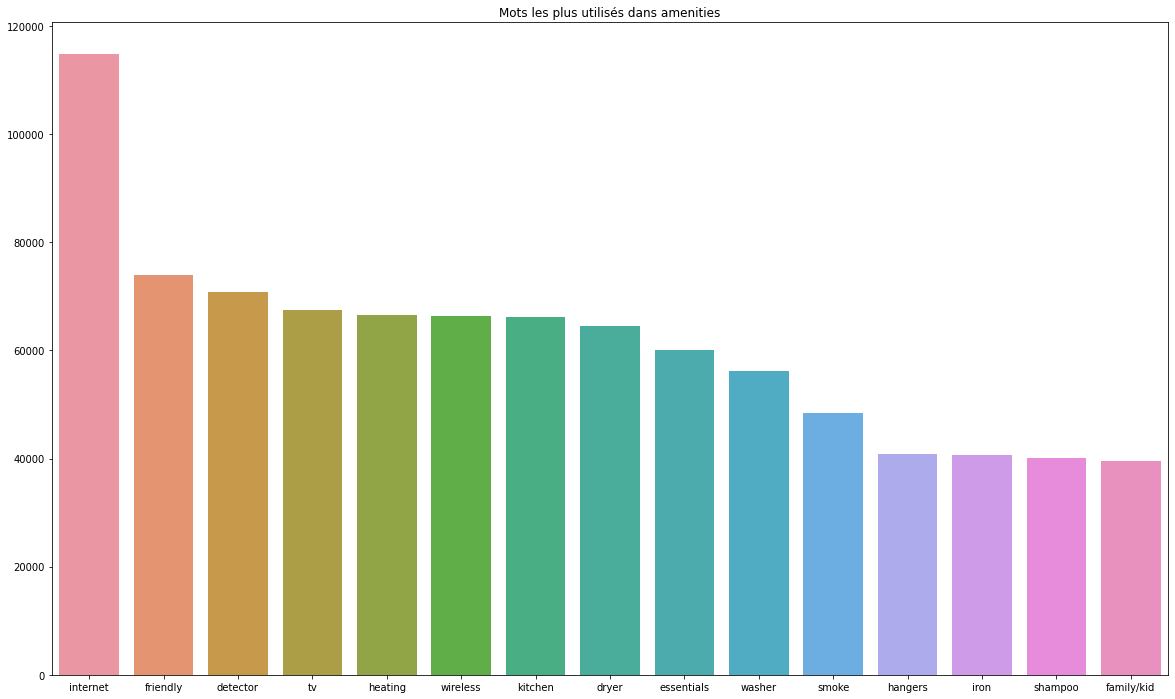

In [ ]:
from collections import Counter
import seaborn as sns
dico=Counter(filtered_amenities)
mots=[m[0] for m in dico.most_common(15)]
freq=[m[1] for m in dico.most_common(15)]
plt.figure(figsize=(20,12))
sns.barplot(x=mots,y=freq)
plt.title("Mots les plus utilisés dans amenities");

# internet est le mot le plus utilisé et wireless vient en 6è position

In [ ]:
#on cherche les mots qui reviennent le plus dans la variable interaction dans les annonces qui ont le plus de reviews et dans celles qui en ont le moins
# on peut ainsi voir si la façon dont l'hôte dit communiquer avec ses invités peut avoir une incidence sur le nombre de reviews

In [ ]:
df_nombreuses_reviews=df[df.number_of_reviews>=300]


In [ ]:
interaction_string = "\n\n".join(df_nombreuses_reviews.interaction)

In [ ]:
interaction_string = re.sub('\s+',' ',interaction_string).strip().lower()
interaction_string[:600]

r=re.compile(r"[0-9]")
interaction_string=r.sub(" ",interaction_string)

r=re.compile(r"[\-\.\:\)\(\,\+\*\#\!\?\@\°\<\>\&\;\'\"\[\]]")
interaction_string=r.sub(" ",interaction_string)

r=re.compile(r"[\s]{2,}")
interaction_string=r.sub(" ",interaction_string)

r=re.compile(r"\bdb\b")
interaction_string=r.sub("double",interaction_string)

r=re.compile(r"\bwi\sfi\b")
interaction_string=r.sub("wifi",interaction_string)

r=re.compile(r"\bnr\b")
interaction_string=r.sub("near",interaction_string)

interaction_string[:600]

'about ten days before your arrival i send you my complete address and phone number when you communicate me your arrival time and according to your place of arrival i write you the best way to get to the apartment i inform you about the district and give you the advice of visits strolls shows entertainments restaurants communication is always very smooth phone use the phone inside the apartment text messages my cell is phone number hidden airbnb messages i ll be there for check in and check out very quickly to give you more time to enjoy paris for lugages i have safety room to keep for you if y'

In [ ]:
tokenizer=PunktSentenceTokenizer()
tokenizer.tokenize(interaction_string)
interaction_string_tokenized=word_tokenize(interaction_string,language="english")

In [ ]:
stop_words=set(stopwords.words("english"))
stop_words.update(["br","two","k","bd","and","br","m","one","st","l","s","also",".",",","(",")","..."])

def stop_words_filtering(interaction_string_tokenized) : 
    tokens = []
    for mot in interaction_string_tokenized:
        if mot not in stop_words:
            tokens.append(mot)
    return tokens

filtered_interaction = [w for w in interaction_string_tokenized if not w.lower() in stop_words]
filtered_interaction = []
 
for w in interaction_string_tokenized:
    if w not in stop_words:
        filtered_interaction.append(w)

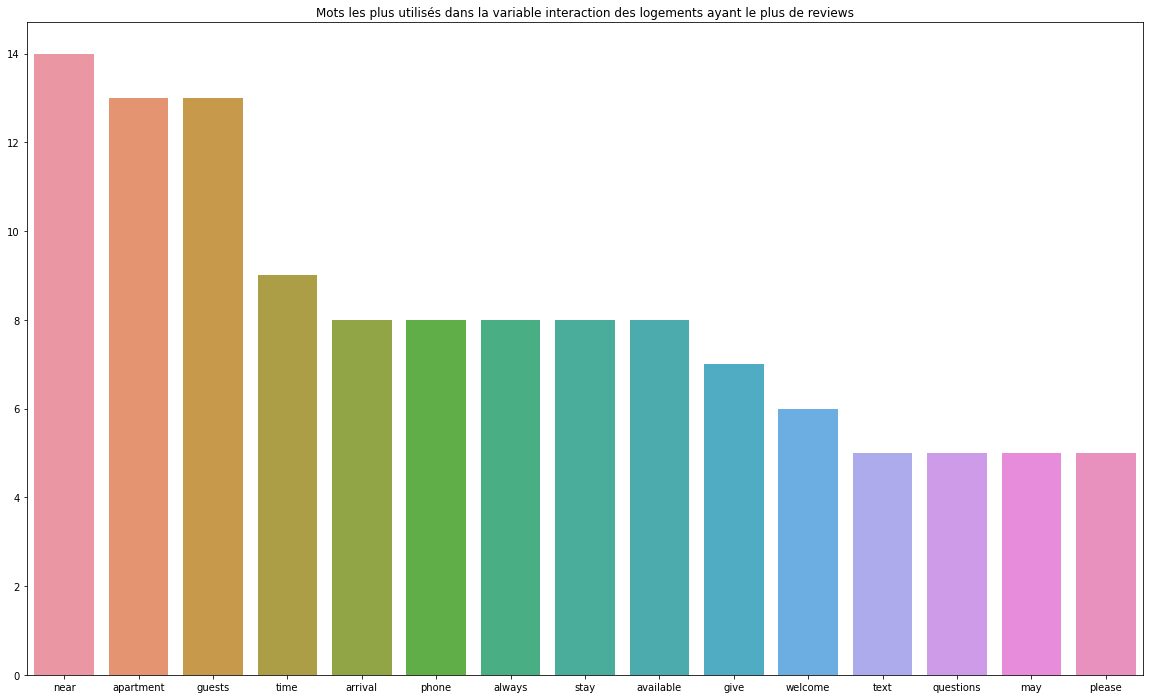

In [ ]:
vectorizer=CountVectorizer()
vectorizer.fit_transform(filtered_interaction)
tokenized=vectorizer.vocabulary_

dico=Counter(filtered_interaction)
mots=[m[0] for m in dico.most_common(15)]
freq=[m[1] for m in dico.most_common(15)]
plt.figure(figsize=(20,12))
sns.barplot(x=mots,y=freq)
plt.title("Mots les plus utilisés dans la variable interaction des logements ayant le plus de reviews");

In [ ]:
# le mot le plus fréquent est near, ce qui signifie peut-être qu'il est important que le propriétaire soit proche du logement loué. 
# on remarque que la notion de disponibilité, d'horaires, de moyens de communication et d'accueil sont importants. 

In [ ]:
# regardons maintenant les mots des annonces ayant le moins de reviews 
df_peu_reviews=df[df.number_of_reviews <= 10]


In [ ]:
interaction_string_peu_reviews = "\n\n".join(df_peu_reviews.interaction)

In [ ]:
interaction_string_peu_reviews = re.sub('\s+',' ',interaction_string_peu_reviews).strip().lower()

r=re.compile(r"[0-9]")
interaction_string_peu_reviews=r.sub(" ",interaction_string_peu_reviews)

r=re.compile(r"[\-\.\:\)\(\,\+\*\#\!\?\@\°\<\>\&\;\'\"\[\]]")
interaction_string_peu_reviews=r.sub(" ",interaction_string_peu_reviews)

r=re.compile(r"[\s]{2,}")
interaction_string_peu_reviews=r.sub(" ",interaction_string_peu_reviews)

r=re.compile(r"\bdb\b")
interaction_string_peu_reviews=r.sub("double",interaction_string_peu_reviews)

r=re.compile(r"\bwi\sfi\b")
interaction_string_peu_reviews=r.sub("wifi",interaction_string_peu_reviews)

r=re.compile(r"\bnr\b")
interaction_string_peu_reviews=r.sub("near",interaction_string_peu_reviews)


In [ ]:
tokenizer=PunktSentenceTokenizer()
tokenizer.tokenize(interaction_string_peu_reviews)
interaction_string_peu_reviews_tokenized=word_tokenize(interaction_string_peu_reviews,language="english")

In [ ]:
stop_words=set(stopwords.words("english"))
stop_words.update(["br","two","k","bd","and","br","m","one","st","l","s","also","à","et","de","je","pour"])


def stop_words_filtering(interaction_string_peu_reviews_tokenized) : 
    tokens = []
    for mot in interaction_string_peu_reviews_tokenized:
        if mot not in stop_words:
            tokens.append(mot)
    return tokens

filtered_interaction_peu_reviews = [w for w in interaction_string_peu_reviews_tokenized if not w.lower() in stop_words]
filtered_interaction_peu_reviews = []
 
for w in interaction_string_peu_reviews_tokenized:
    if w not in stop_words:
        filtered_interaction_peu_reviews.append(w)

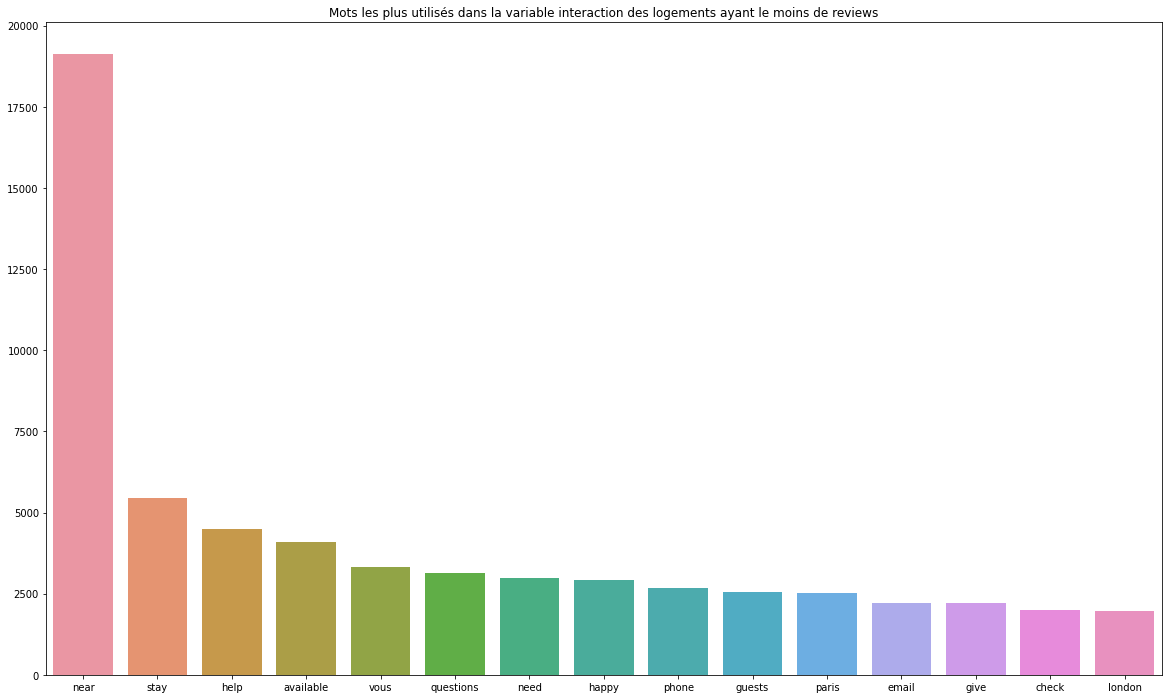

In [ ]:
vectorizer=CountVectorizer()
vectorizer.fit_transform(filtered_interaction_peu_reviews)
tokenized=vectorizer.vocabulary_

dico=Counter(filtered_interaction_peu_reviews)
mots=[m[0] for m in dico.most_common(15)]
freq=[m[1] for m in dico.most_common(15)]
plt.figure(figsize=(20,12))
sns.barplot(x=mots,y=freq)
plt.title("Mots les plus utilisés dans la variable interaction des logements ayant le moins de reviews");

In [ ]:
# on remarque que les annonces ayant le moins de reviews ne contiennent pas la notion d'accueil et que le moyen de communication essentiel semble être l'e-mail,
# ce qui est moins rapide qu'un appel ou un texto. "always" n'est pas non plus présent ici, ce ui montre une plus grande distanciation entre l'hôte et ses clients.
# Cependant, le mot happy apparaît ici alors qu'il n'apparaît pas dans les annonces ayant le plus de reviews. 